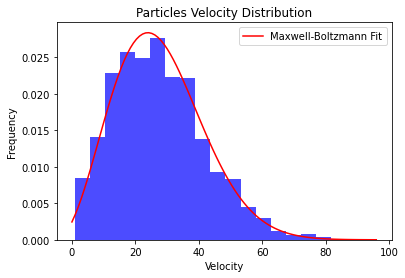

In [3]:
import pygame
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy import stats


# Initialize Pygame
pygame.init()

# Simulation parameters
num_particles = 100
box_width = 800
box_height = 600
radius = 10
time_step = 0.1
temperature = 1000  # Desired temperature

# Initialize screen
screen = pygame.display.set_mode((box_width, box_height))
pygame.display.set_caption("Hard Sphere Molecular Dynamics")

# Colors
white = (255, 255, 255)
blue = (0, 0, 255)

# Maxwell-Boltzmann distribution function for velocities
def maxwell_boltzmann(v, m, T):
    return (m / (2 * np.pi * 1.38e-23 * T)) ** 0.5 * np.exp(-m * v ** 2 / (2 * 1.38e-23 * T))

# Initialize particles with random positions and velocities based on Maxwell-Boltzmann distribution
particles = []
for _ in range(num_particles):
    x = np.random.uniform(radius, box_width - radius)
    y = np.random.uniform(radius, box_height - radius)
    # Generate velocities from Maxwell-Boltzmann distribution
    vx = np.random.normal(0, np.sqrt(temperature / 2))
    vy = np.random.normal(0, np.sqrt(temperature / 2))
    particles.append({'position': np.array([x, y]),
                      'velocity': np.array([vx, vy]),
                      'radius': radius})

def update_particles():
    for particle in particles:
        particle['position'] += particle['velocity'] * time_step

def handle_wall_collisions():
    for particle in particles:
        if particle['position'][0] <= particle['radius'] or particle['position'][0] >= box_width - particle['radius']:
            particle['velocity'][0] *= -1
        if particle['position'][1] <= particle['radius'] or particle['position'][1] >= box_height - particle['radius']:
            particle['velocity'][1] *= -1

def handle_particle_collisions():
    for i in range(len(particles)):
        for j in range(i + 1, len(particles)):
            particle_i = particles[i]
            particle_j = particles[j]
            distance = np.linalg.norm(particle_i['position'] - particle_j['position'])
            if distance <= particle_i['radius'] + particle_j['radius']:
                overlap = particle_i['radius'] + particle_j['radius'] - distance
                normal = (particle_i['position'] - particle_j['position']) / distance
                relative_velocity = particle_i['velocity'] - particle_j['velocity']
                impulse = 2 * np.dot(relative_velocity, normal) / (1 / particle_i['radius'] + 1 / particle_j['radius'])
                particle_i['velocity'] -= impulse / particle_i['radius'] * normal
                particle_j['velocity'] += impulse / particle_j['radius'] * normal
                # Move particles apart to eliminate overlap
                displacement = 0.5 * overlap * normal
                particle_i['position'] += displacement
                particle_j['position'] -= displacement
                
def draw_particles():
    screen.fill(white)
    for particle in particles:
        pygame.draw.circle(screen, blue, particle['position'].astype(int), particle['radius'])

def main():
    running = True
    velocities = []  # List to store velocities for histogram
    
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        update_particles()
        handle_wall_collisions()
        handle_particle_collisions()
        draw_particles()
        pygame.display.flip()

        # Collect velocities for histogram
        velocities.extend([np.linalg.norm(p['velocity']) for p in particles])

    # Create and display histogram plot
    plt.hist(velocities, bins=20, density=True, alpha=0.7, color='blue')
    plt.xlabel('Velocity')
    plt.ylabel('Frequency')
    plt.title('Particles Velocity Distribution')

    # Fit a Maxwell-Boltzmann distribution to the histogram
    params = stats.maxwell.fit(velocities)
    x = np.linspace(0, np.max(velocities), 100)
    fitted_pdf = stats.maxwell.pdf(x, *params)
    plt.plot(x, fitted_pdf, color='red', label='Maxwell-Boltzmann Fit')
    plt.savefig('100and300k.png')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()